# これは何？
networkx 2.1(2018/5/27現在の最新安定版)のfrom_pandas_adjacency関数の仕様確認をした際のメモ書きです。
- from_pandas_adjacency()
    + https://networkx.github.io/documentation/networkx-2.1/reference/generated/networkx.convert_matrix.from_pandas_adjacency.html#networkx.convert_matrix.from_pandas_adjacency
    + networkx 2.0から追加された関数。
    + pandasのDataFrame構造で作った隣接行列をnetworkxのグラフ構造に変換する。とても便利。
    
# なぜ調べたの？
- 最近作っているPEPの参照関係の可視化(リポジトリ: https://github.com/komo-fr/pep_map_site ）を作っている際に、**「隣接行列（pandasのDataFrame形式）の中身は正しいのにfrom_pandas_adjacency関数で生成したグラフ構造が意図しない形になる」現象**に遭遇しました
    + 具体的には、被参照数No1のPEP 8に対する入次数が2しかない、みたいな現象。   
- **「pandasの行名と列名の並び順を揃える」ことで解決した** (https://bit.ly/2IN5m0R ) ので、おそらくpandasのラベル名を見ずに行と列の順序の対応でエッジを張っているのだと思うのですが、なんか気持ち悪いので小さいデータで確認してみることにしました。

# 使い方に関する結論
先に結論を書くと、   
- networkx 2.1(2018/5/27現在の最新安定版）でfrom_pandas_adjacencyを使用する際は、pandasのデータフレームの行名・列名は並び順を揃えて渡すこと！
- でないと、意図しない構造に変換される恐れがある。   
   
詳細は下記の通り。

# ライブラリのバージョン

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from IPython.display import display

In [2]:
print('pandas: {}'.format(pd.__version__))
print('networkx: {}'.format(nx.__version__))

pandas: 0.21.0
networkx: 2.1


補足：   
- networkx 1.9以前では、そもそもfrom_pandas_adjacency関数自体が存在しないので、下記のコードは実行できません。
- networkx 2.0では、関数自体は存在するものの、下記不具合により無向グラフ以外への変換ができないので、下記のコードの実行結果が変わると思います。
    + issue: https://github.com/networkx/networkx/issues/2828 （2.1では修正済）
    + 2.0環境で以下のコードを実行すると、有向グラフではなく無向グラフが表示されてしまうはず。今回の現象自体は無向グラフ・有向グラフは関係ないので、今回の本題の確認自体はできると思います。ただし、私は2.0環境では確認していないので、気になる人は自分でやってみてね。

# 詳細（確認の手順）

## 確認1: 行名・列名が同じで、行順・列順も同じ場合
うまくいくケース

,A,B,C
A,0,1,0
B,0,0,1
C,0,0,0


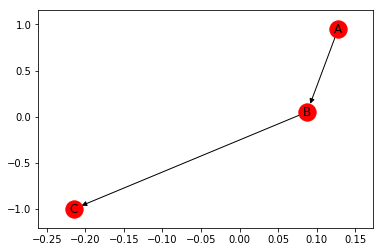

In [3]:
# A->B, B->C, Cは誰も見ていない
data = {"A": {"A": 0, "B" : 0, "C": 0},
            "B": {"A": 1, "B" : 0, "C": 0},
            "C": {"A": 0, "B" : 1, "C": 0}
           }
a_df = pd.DataFrame(data)
display(a_df)

# 変換
G  = nx.from_pandas_adjacency(a_df, create_using=nx.DiGraph())
# 表示
pos=nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos=pos)
nx.draw_networkx_labels(G, pos=pos)
nx.draw_networkx_edges(G, pos=pos)
plt.show()

### 結果 
意図通りの構造で変換される。

## 確認2: 行名・列名が同じで、行順・列順が異なる場合
行名と列名が同じだが、行と列で並び順が異なったらどうなるか？   
例えば列の順をA, B, CからA, C, Bにした場合、
- 予想1: 確認1と同じ結果になり、列名を基準とした構造になる
    + A→B, B→C, Cは誰も見ていない
- 予想2: 確認1と違う結果になる

,A,C,B
A,0,0,1
B,0,1,0
C,0,0,0


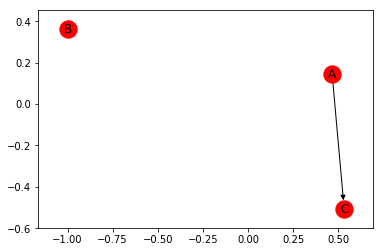

In [4]:
# A->B, B->C, Cは誰も見ていない（確認1と組み合わせは同じ）
data = {"A": {"A": 0, "B" : 0, "C": 0},
            "B": {"A": 1, "B" : 0, "C": 0}, 
            "C": {"A": 0, "B" : 1, "C": 0}
           }
df = pd.DataFrame(data)
df = df[["A", "C", "B"]]  # ★列の並びを行とは違う順にする
display(df)

# 変換
G  = nx.from_pandas_adjacency(df, create_using=nx.DiGraph())
# 表示
pos=nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos=pos)
nx.draw_networkx_labels(G, pos=pos)
nx.draw_networkx_edges(G, pos=pos)
plt.show()

## 結果    
予想2: 確認1と違う結果になる。   
ただし、何故こういう違い方になるのかがわからない。枝は2本あったはずなのに、何故1本になってるの？

# なぜこうなる？
## from_pandas_adjacencyの中身を見てみる
- source(2.1): https://networkx.github.io/documentation/networkx-2.1/_modules/networkx/convert_matrix.html#from_pandas_adjacency

In [5]:
def from_pandas_adjacency(df, create_using=None):
    """
    networkx 2.1のfrom_pandas_adjacencyの中身。
    元のコード： https://networkx.github.io/documentation/networkx-2.1/_modules/networkx/convert_matrix.html#from_pandas_adjacency
    関数コメントは長いので省略。★マーク付のコメントは私（komo-fr)のコメント
    """
    # ★列順と行順を揃える前に、numpy配列の形で
    A = df.values
    G = from_numpy_matrix(A, create_using=create_using)
    try:
        df = df[df.index]  # ★ここで行順と列順を揃えている
    except:
        raise nx.NetworkXError("Columns must match Indices.", "%s not in columns" %
                               list(set(df.index).difference(set(df.columns))))

    nx.relabel.relabel_nodes(G, dict(enumerate(df.columns)), copy=False)  # ★sort後の列順を使って、sort前のnumpy配列で作ったノードにマッピングしている
    return G

行順と列順を揃える前のデータからグラフ構造を作り、行順と列順を揃えた後にノードのラベルの張り替えをしているので、意図しない構造になっているようだ。試しに、下記の通りグラフ構造生成前に行順と列順を揃えて実行してみる。

## 修正案

In [6]:
def from_pandas_adjacency_after(df, create_using=None):
    """ 
    修正案
    """
    try:  # ★先に行順と列順を揃える
        df = df[df.index]
    except:
        raise nx.NetworkXError("Columns must match Indices.", "%s not in columns" %
                               list(set(df.index).difference(set(df.columns))))
    
    A = df.values
    G = nx.from_numpy_matrix(A, create_using=create_using)  # ★Jupyter上で動かすためにnxをつけている。実際のコードの修正ではここの変更は不要

    nx.relabel.relabel_nodes(G, dict(enumerate(df.columns)), copy=False)
    return G

,A,C,B
A,0,0,1
B,0,1,0
C,0,0,0


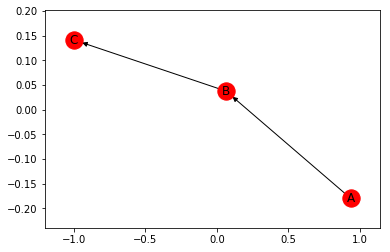

In [7]:
# 簡単な修正確認
data = {"A": {"A": 0, "B" : 0, "C": 0},
            "B": {"A": 1, "B" : 0, "C": 0}, 
            "C": {"A": 0, "B" : 1, "C": 0}
           }
df = pd.DataFrame(data)
df = df[["A", "C", "B"]]  # ★列の並びを行とは違う順にする
display(df)

# 変換
G  = from_pandas_adjacency_after(df, create_using=nx.DiGraph())  # ★修正した関数を使ってみる
# 表示
pos=nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos=pos)
nx.draw_networkx_labels(G, pos=pos)
nx.draw_networkx_edges(G, pos=pos)
plt.show()

意図通り（行名・列名に基づいて）グラフ構造を生成・描画できた。

## なぜ2本あった枝が1本になったのか
確認2で用意したデータの場合、下記の通りセルフループになるため描画時に表示されなかったようだ。

列名・行名に惑わされず順序だけで見ると、2行目と2列目が接続＝セルフループになっている
[[0 0 1]
 [0 1 0]
 [0 0 0]]
ラベルを張り替える前のエッジ: [(0, 2), (1, 1)]
ラベル張り替えの対応: {0: 'A', 1: 'B', 2: 'C'}
ラベルを張り替えた後のエッジ: [('A', 'C'), ('B', 'B')]


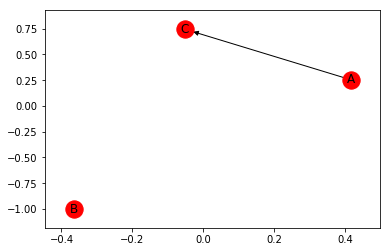

In [8]:
# 確認2と同じデータを用意する
data = {"A": {"A": 0, "B" : 0, "C": 0},
            "B": {"A": 1, "B" : 0, "C": 0}, 
            "C": {"A": 0, "B" : 1, "C": 0}
           }
df= pd.DataFrame(data)
df = df[["A", "C", "B"]]  # ★列の並びを行とは違う順にする

print('列名・行名に惑わされず順序だけで見ると、2行目と2列目が接続＝セルフループになっている')
print(df.values) 

create_using = nx.DiGraph()
A = df.values

G = nx.from_numpy_matrix(A, create_using=create_using)

df = df[df.index]  # 行順と列順を揃える
print('ラベルを張り替える前のエッジ: {}'.format(G.edges()))

nx.relabel.relabel_nodes(G, dict(enumerate(df.columns)), copy=False)
print('ラベル張り替えの対応: {}'.format(dict(enumerate(df.columns))))
print('ラベルを張り替えた後のエッジ: {}'.format(G.edges()))
pos=nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos=pos)
nx.draw_networkx_labels(G, pos=pos)
nx.draw_networkx_edges(G, pos=pos)
plt.show()

## これ不具合なの？？
個人的には、pandasのDataFrameで（0始まりの連番ではなく）あえて行名・列名をつけているときは、それをノード名として解釈するのが自然だし不具合の元にならないと思う（現状の動きだと、関数を呼ぶ側がいちいち行順と列順を意識する必要があり、意図しないグラフ構造に変換される恐れがある）。

- GitHub上のmasterブランチの当該関数を確認したところ、現時点（2018/5/27）時点では特に変更はない。
    - https://github.com/networkx/networkx/blob/master/networkx/convert_matrix.py 
- まだちゃんと確認しきれていないけど、issueとmasterにマージされていないpull requestをざっと眺めたところ、特に誰も言及していないっぽい？
    + 確認したら、issue立ててpull request投げることを検討する。

# 結論（再）
- networkx 2.1(2018/5/27現在の最新安定版）でfrom_pandas_adjacencyを使用する際は、pandasのデータフレームの行名・列名は並び順を揃えて渡すこと！
- でないと、意図しない構造に変換される恐れがある。  

# 番外編

## 番外1: 行名・列名が異なる場合
行の名前と列の名前が異なっていたらどうなる？   
例えば列名をA, B, <font color="red">ccc</font>に変更した場合、
- 予想1: エラーになってそもそも変換できない
- 予想2: エラーにならず変換され、ノードが4つ表示される（A, B, C, ccc)
- 予想3: エラーになって変換されるが、ノードは3つのままで、確認2のようによくわからない枝の張り方がされる
- 予想4: それ以外

In [9]:
data = {"A": {"A": 0, "B" : 0, "C": 0},
            "B": {"A": 1, "B" : 0, "C": 0}, 
            "ccc": {"A": 0, "B" : 1, "C": 0}
           }  # ★ 行名と列名を変更する
df = pd.DataFrame(data)
display(df)

# 変換
G  = nx.from_pandas_adjacency(df, create_using=nx.DiGraph())
# 表示
pos=nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos=pos)
nx.draw_networkx_labels(G, pos=pos)
nx.draw_networkx_edges(G, pos=pos)
plt.show()

,A,B,ccc
A,0,1,0
B,0,0,1
C,0,0,0


NetworkXError: ('Columns must match Indices.', "['C'] not in columns")

### 結果
予想1: エラーになってそもそも変換できない   
※ NetworkXErrorが発生する

## 番外2: 行名・列名を明示的に指定しない場合
そもそも列名・行名をつけていなかったらどうなる？   
- 予想1: 行名・列名が0始まりの連番になるので、結果的に行名・列名・その並び順が揃い、問題なく変換・表示ができる
    + というか、Officialのドキュメントのサンプルコードではそうなっている。
       * networkx.convert_matrix.from_pandas_adjacency: https://networkx.github.io/documentation/stable/reference/generated/networkx.convert_matrix.from_pandas_adjacency.html#networkx.convert_matrix.from_pandas_adjacency
- 予想2: それ以外

,0,1,2
0,0,1,0
1,0,0,1
2,0,0,0


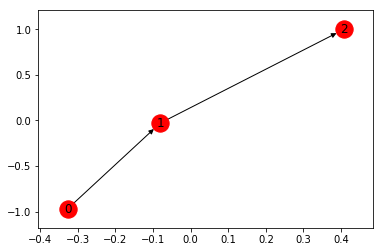

In [10]:
df = pd.DataFrame([[0, 1, 0], 
                              [0, 0, 1],
                              [0, 0, 0]])
display(df)

# 変換
G  = nx.from_pandas_adjacency(df, create_using=nx.DiGraph())
# 表示
pos=nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos=pos)
nx.draw_networkx_labels(G, pos=pos)
nx.draw_networkx_edges(G, pos=pos)

,0,1,2
0,0,1,0
1,0,0,1
2,0,0,0


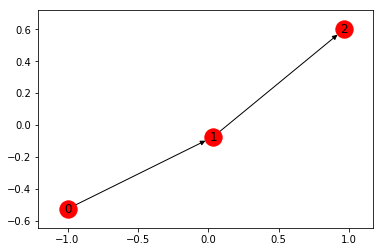

In [11]:
df = pd.DataFrame([[0, 1, 0], 
                              [0, 0, 1],
                              [0, 0, 0]])
display(df)

# 変換
G  = nx.from_numpy_matrix(df.values, create_using=nx.DiGraph())
# 表示
pos=nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos=pos)
nx.draw_networkx_labels(G, pos=pos)
nx.draw_networkx_edges(G, pos=pos)
plt.show()

### 結果
予想1: 行名・列名が0始まりの連番になるので、結果的に行名・列名・その並び順が揃い、問題なく変換・表示ができる（当たり前っちゃ当たり前）